## Linear regression

In [39]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### Data preprocessing

In [26]:
df = pd.read_csv('podatki_PM.csv')

print('Null values: \n',df.isnull().sum())
df = df.drop(columns=['Datum'])

df.fillna(df.mean(), inplace=True)

print('Null values: \n',df.isnull().sum())
print('\n')
num_instances, num_features = df.shape
df['PM10'].astype(float) 
print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")


Null values: 
 Datum                         0
Glob_sevanje_mean             0
Hitrost_vetra_mean            0
Sunki_vetra_max               0
Padavine_sum                  0
Vlaga_mean                    0
Temperatura_Krvavec_mean      0
Temperatura_lokacija_mean     0
PM10                          0
PM_vceraj                    33
sinD                          0
cosD                          0
dtype: int64
Null values: 
 Glob_sevanje_mean            0
Hitrost_vetra_mean           0
Sunki_vetra_max              0
Padavine_sum                 0
Vlaga_mean                   0
Temperatura_Krvavec_mean     0
Temperatura_lokacija_mean    0
PM10                         0
PM_vceraj                    0
sinD                         0
cosD                         0
dtype: int64


Number of instances: 1213
Number of features: 11


### Data splitting and Target variable selection

In [27]:
y = df['PM10']  # Target variable
X = df.drop(columns=['PM10'])  # Features               

# 70/30 train-test split without random shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Training features shape: (849, 10)
Testing features shape: (364, 10)
Training target shape: (849,)
Testing target shape: (364,)


### Multiple Linear Regression

In [28]:
class MultipleLinearRegression:
    def __init__(self):
        self.beta = None 

    def fit(self, X, y):
        """
        Fit the model using the normal equation.
        
        Parameters:
        X : numpy array or pandas DataFrame
            The input features (matrix).
        y : numpy array or pandas Series
            The target variable (vector).
        """
        X = np.c_[np.ones(X.shape[0]), X]

        # Coefficients calculation
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        """
        Predict the target variable using the learned coefficients.
        
        Parameters:
        X : numpy array or pandas DataFrame
            The input features for prediction.
        
        Returns:
        numpy array
            The predicted values.
        """
        X = np.c_[np.ones(X.shape[0]), X]
        
        return X @ self.beta

    def get_coefficients(self):
        """
        Get the learned coefficients of the model.
        
        Returns:
        numpy array
            The coefficients of the model.
        """
        return self.beta

In [34]:
model = MultipleLinearRegression()
model.fit(X_train, y_train)
y_pred_custom = model.predict(X_train)
print("Calculated coefficients (beta):", model.get_coefficients())

Calculated coefficients (beta): [ 4.64121501e+01  3.25713628e-02 -2.83160750e+00 -9.68148514e-01
 -2.27105425e-01 -2.37595054e-01  4.71115184e-01 -1.18019711e+00
  5.47713643e-01 -2.57394213e+00  1.53883545e+00]


### Test: Compare the manually written linear regression model with the scikit-learn model

In [37]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"R-squared: {r2:.3f}\n")

#### Fit the linear regression model from scikit-learn

In [32]:
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_train)

#### Custom model and scikit-learn model evaluation

In [38]:
evaluate_model(y_train, y_pred_custom, "Custom Multiple Linear Regression")
evaluate_model(y_train, y_pred_sklearn, "Scikit-Learn Linear Regression")

Custom Multiple Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667

Scikit-Learn Linear Regression Performance:
Mean Absolute Error: 6.536
Mean Squared Error: 86.436
R-squared: 0.667



### Diagnose your linear regression with the diagnostic plots

### Residual analysis 

Custom Multiple Linear Regression Performance


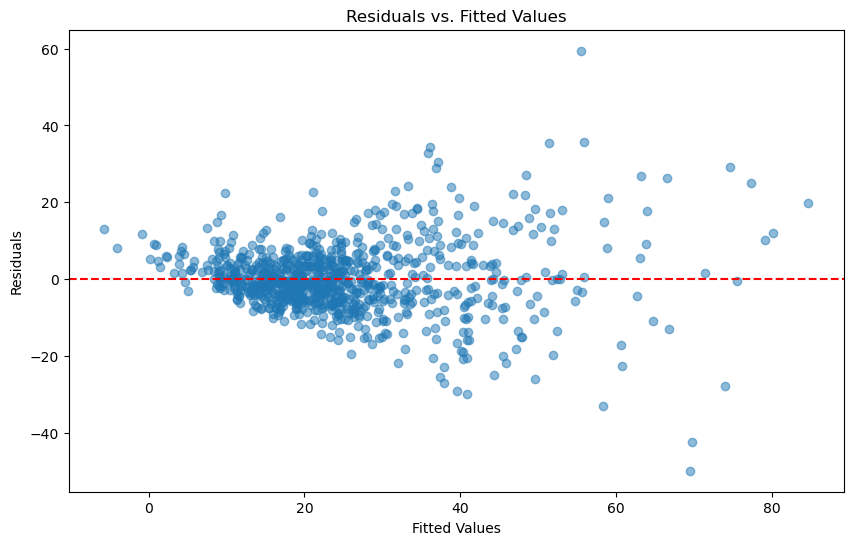

In [40]:
# plot the residuals 
print('Custom Multiple Linear Regression Performance')
residuals = y_train - y_pred_custom

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_custom, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Scikit-Learn Linear Regression


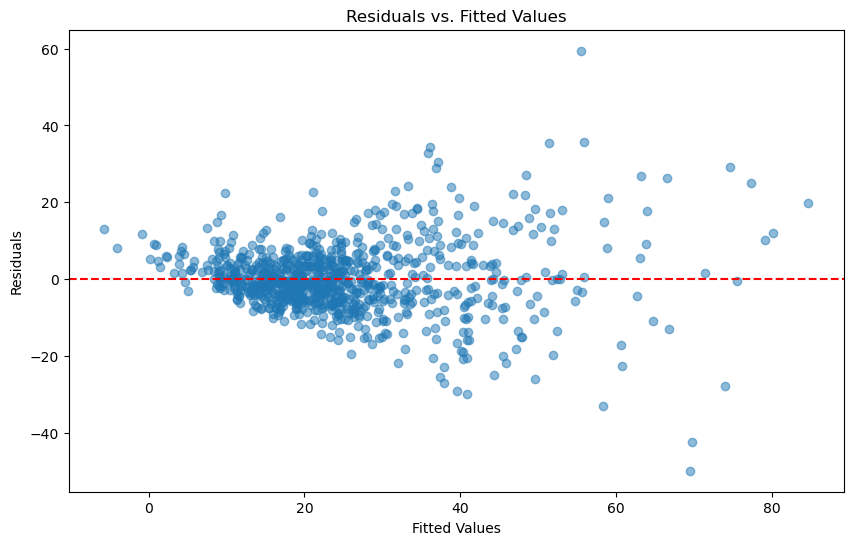

In [41]:
# plot the residuals 
print('Scikit-Learn Linear Regression')
residuals = y_train - y_pred_sklearn

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_sklearn, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

### Improvements